# Potwierdzam samodzielność powyższej pracy oraz niekorzystanie przeze mnie z niedozwolonych źródeł. Olaf Werner¶

In [310]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from copy import deepcopy

In [311]:
np.random.seed(123)

## maksymalizujemy fit więc mnożymy przez -1

In [312]:
def cross_entropy(targets,predictions,  epsilon=1e-12):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    ce = abs(np.sum(targets*np.log(predictions)))
    return -ce

In [313]:
def MSE(Y,Y_hat):
    return -np.sum((Y-Y_hat)**2)

# NeuroEvolution of Augmenting Topologies NEAT

In [314]:
class NEAT:
    
    class network:
        def __init__(self,gen_input_size,gen_output_size,var):
            #node genes
            self.gen_node=np.ones((gen_input_size+gen_output_size,2)).astype(int)
            #first col neuron number
            self.gen_node[:,0]=np.arange(gen_input_size+gen_output_size).astype(int)
            #second column type of neuron -1 input,1 output, 0 hidden
            self.gen_node[:gen_input_size,1]=-1
            #connection gen
            self.gen_con=np.ones((gen_input_size*gen_output_size,5))
            #first column innovation number, second  input, third  output, fourth weight, fifth activ
            k=0
            for i in range(gen_input_size):
                for j in range(gen_output_size):
                    self.gen_con[k,0]=k
                    self.gen_con[k,1]=i
                    self.gen_con[k,2]=gen_input_size+j
                    k+=1
            
            self.gen_input_size=gen_input_size
            self.gen_output_size=gen_output_size
            self.var=var
            #local base for tracking hom many times connection was used for adding nodes
            self.mini_gen_base={}
            
        
        def mutate_weight(self):
            con_id_rel=np.random.randint(self.gen_con.shape[0])
            self.gen_con[con_id_rel,3]=self.gen_con[con_id_rel,3]+np.random.normal(0,self.var)
            
        def mutate_activation(self):
            con_id_rel=np.random.randint(self.gen_con.shape[0])
            if self.gen_con[con_id_rel,4]==1:
                self.gen_con[con_id_rel,4]=0
            else:
                self.gen_con[con_id_rel,4]=1
                
        
        #def add_connection(self,con_base,last_con):
        #   node_id_rel=np.random.randint(self.gen_con.shape[0])
            
            
        
        def mutate_add_neuron(self,gen_base,con_base,last_node,last_con):
            #relative id
            con_id_rel=np.random.randint(self.gen_con.shape[0])
            #global id
            con_id=self.gen_con[con_id_rel][0]
            con_id=int(con_id)
            node=gen_base.get(con_id)
            #deactivate
            self.gen_con[con_id_rel,4]=0
            if node==None:
                #add new connections
                self.gen_con=np.append(self.gen_con,np.array([[last_con[0],self.gen_con[con_id_rel,1],last_node[0],1,1]]),axis=0)
                self.gen_con=np.append(self.gen_con,np.array([[last_con[0]+1,last_node[0],self.gen_con[con_id_rel,2],self.gen_con[con_id_rel,3],1]]),axis=0)
                #update base
                self.mini_gen_base.update({con_id:1})
                gen_base.update({con_id:[last_node[0]]})
                con_base.update({(self.gen_con[con_id_rel,1],last_node[0]):last_con[0]})
                con_base.update({(last_node[0],self.gen_con[con_id_rel,2]):last_con[0]+1})
                self.gen_node=np.append(self.gen_node,np.array([[last_node[0],0]]),axis=0)
                last_con[0]=last_con[0]+2
                last_node[0]=last_node[0]+1
                
            else:
                #check how many times already
                times=self.mini_gen_base.get(con_id)
                if times==None:
                    times=0
                
                times+=1
                
                if times>len(node):
                    #add new connections
                    self.gen_con=np.append(self.gen_con,np.array([[last_con[0],self.gen_con[con_id_rel,1],last_node[0],1,1]]),axis=0)
                    self.gen_con=np.append(self.gen_con,np.array([[last_con[0]+1,last_node[0],self.gen_con[con_id_rel,2],self.gen_con[con_id_rel,3],1]]),axis=0)
                    #update base
                    self.mini_gen_base.update({con_id:times})
                    gen_base.update({con_id:node+[last_node[0]]})
                    con_base.update({(self.gen_con[con_id_rel,1],last_node[0]):last_con[0]})
                    con_base.update({(last_node[0],self.gen_con[con_id_rel,2]):last_con[0]+1})
                    self.gen_node=np.append(self.gen_node,np.array([[last_node[0],0]]),axis=0)
                    last_con[0]=last_con[0]+2
                    last_node[0]=last_node[0]+1
                else:
                    #add new connections based on bases
                    node=node[times-1]
                    self.gen_con=np.append(self.gen_con,np.array([[con_base.get((self.gen_con[con_id_rel,1],node)),self.gen_con[con_id_rel,1],node,1,1]]),axis=0)
                    self.gen_con=np.append(self.gen_con,np.array([[con_base.get((node,self.gen_con[con_id_rel,2])),node,self.gen_con[con_id_rel,2],self.gen_con[con_id_rel,3],1]]),axis=0)
                    #update base
                    self.mini_gen_base.update({con_id:times})
                    self.gen_node=np.append(self.gen_node,np.array([[node,0]]),axis=0)
                    
        def forward(self,data):
            memory={}
            def backward(node):
                #check if is input
                if node[1]==-1:
                    memory.update({node[0]:data[:,node[0]]})
                    return data[:,node[0]]
                
                suma=np.zeros(data.shape[0])
                connect=self.gen_con[(self.gen_con[:,2]==node[0]),]
                connect=connect[(connect[:,4]==1),]
                #all connected nodes
                for i in range(connect.shape[0]):
                    val=memory.get(connect[i,1])
                    if np.all(val==None):
                        val=backward(self.gen_node[self.gen_node[:,0]==connect[i,1],:].flatten())
                    
                    suma=suma+val*connect[i,3]
                    
                memory.update({node[0]:suma})
                return suma
            
            return np.array([backward(self.gen_node[i]) for i in range(self.gen_input_size,self.gen_input_size+self.gen_output_size)]).T
                
        
            
            
    def __init__(self,population_size,gen_input_size,gen_output_size,fit_function,var=0.25):
        self.fit_function=fit_function
        self.population=[self.network(gen_input_size,gen_output_size,var) for x in range(population_size)]
        self.gen_input_size=gen_input_size
        self.gen_output_size=gen_output_size
        self.population_size=population_size
        self.var=var
        self.gen_base={}
        self.con_base={}
        self.last_node=[gen_input_size+gen_output_size]
        self.last_con=[gen_input_size*gen_output_size]
        k=0
        for i in range(gen_input_size):
            for j in range(gen_output_size):
                self.con_base.update({(i,gen_input_size+j):k})
                k+=1
        
    
    def normalize(self,z):
        e=z-np.min(z)
        return e/np.sum(e)
    
    
    def softmax(self,z):
        e = np.exp(z)
        return e / np.sum(e, axis=0,keepdims=True)
    
    #def cross(self,par1,par2):
        #return chd1,chd2
    
    
    def fitness(self,data,values):
        fit=np.zeros(self.population_size)
        for i in range(self.population_size):
            p=self.population[i]
            fit[i]=self.fit_function(values,p.forward(data))
            
        return fit
    
    def train(self,generations,data,values):
        fit=np.zeros(self.population_size)
        for g in range(generations):
            new_population=[0 for x in range(self.population_size)]
            for i in range(self.population_size):
                p=self.population[i]
                if np.random.random()>0.66:
                    p.mutate_add_neuron(self.gen_base,self.con_base,self.last_node,self.last_con)
                
                p.mutate_weight()
                p.mutate_activation()
                fit[i]=self.fit_function(values,p.forward(data))
                
            prob=self.normalize(fit)
            parents=np.random.choice(self.population,self.population_size,p=prob)
            #for c in range(self.population_size//2):
            #    new_population[2*c], new_population[2*c+1] = self.cross(parents[2*c],parents[2*c+1])
            for c in range(self.population_size):
                new_population[c]= deepcopy(parents[c])
                
            self.population=new_population
            
                
            

# Test na easy

### Załaduj data set

In [315]:
test = np.loadtxt("easy-training.csv", delimiter=',', skiprows=1, usecols=range(0,3))
np.random.shuffle(test)
X=test[:,0:2]
Y=test[:,2:3]
#one-hot-encode
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_output_layer=Y

In [316]:
test = np.loadtxt("easy-test.csv", delimiter=',', skiprows=1, usecols=range(0,3))
X=test[:,0:2]
Y=test[:,2:3]
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_output_layer=Y

## Inicjalizuj NEAT

In [317]:
test=NEAT(population_size=100,gen_input_size=2,gen_output_size=2,fit_function=cross_entropy,var=0.25)

In [318]:
test.train(40,train_input_layer,train_output_layer)

In [319]:
best_net=test.population[np.argmax(test.fitness(train_input_layer,train_output_layer))]

# Rezultaty

[Text(0.5, 1.0, 'Test data')]

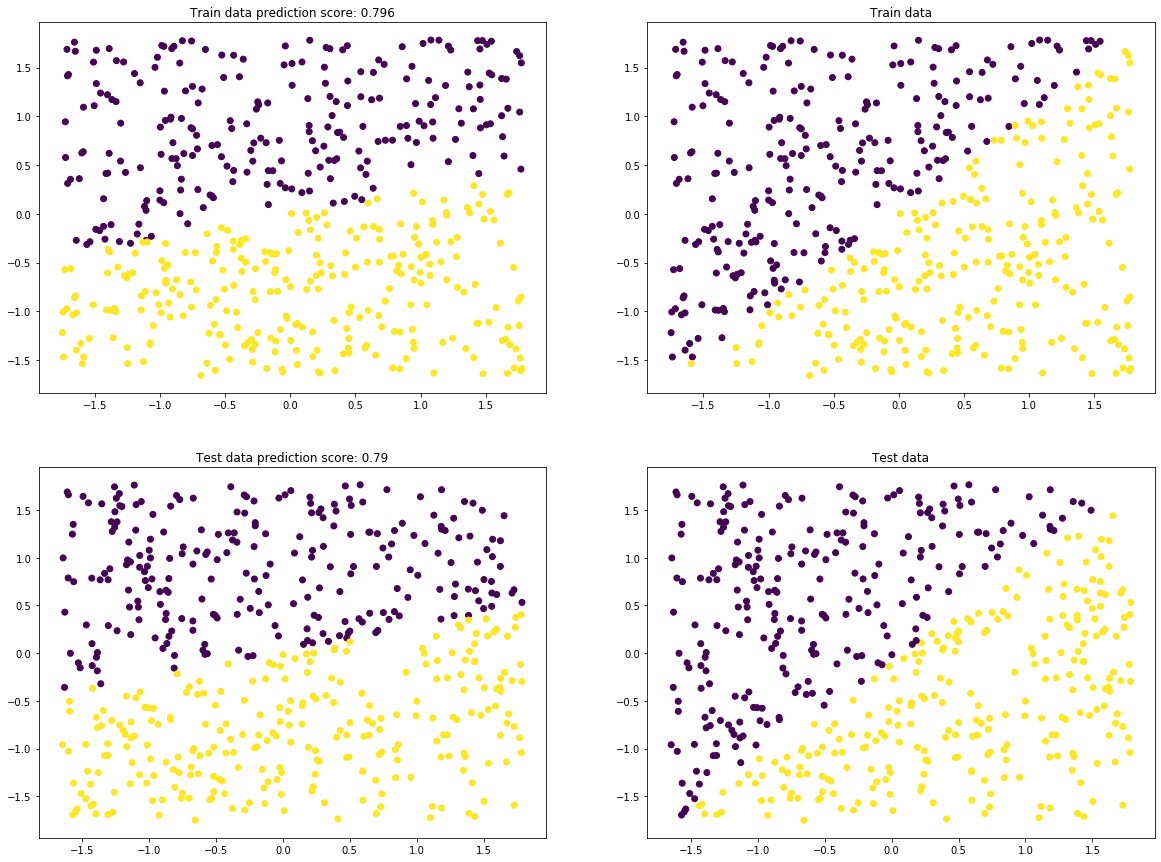

In [320]:
output_layer=best_net.forward(train_input_layer)
fig=plt.figure(figsize=(20,15))
ax=fig.add_subplot(221)
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(output_layer,axis=1))
ax.set(title='Train data prediction score: '+str(round(np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1)),3)))

ax1=fig.add_subplot(222)
ax1.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(train_output_layer,axis=1))
ax1.set(title="Train data")


output_layer=best_net.forward(test_input_layer)

ax2=fig.add_subplot(223)
ax2.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(output_layer,axis=1))
ax2.set(title='Test data prediction score: '+str(round(np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1)),3)))

ax3=fig.add_subplot(224)
ax3.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(test_output_layer,axis=1))
ax3.set(title="Test data")

## Podsumowanie

Otrzymaliśmy w miarę sensowne rezultaty patrząc na to że nie używaliśmy funkcji aktywacji, oraz jeszcze nie zaimplementowaliśmy dodawanie połączeń między neuronami i specjacji.

## parametry najlepszej sieci (aktywne połązenia)

In [321]:
best_net.gen_con[best_net.gen_con[:,4]==1]

array([[  1.        ,   0.        ,   3.        ,   1.28310876,
          1.        ],
       [ 10.        ,   1.        ,   7.        ,   1.08595049,
          1.        ],
       [ 11.        ,   7.        ,   2.        ,   1.20511234,
          1.        ],
       [ 30.        ,   7.        ,  17.        ,   0.93599574,
          1.        ],
       [ 31.        ,  17.        ,   2.        ,   1.27562727,
          1.        ],
       [110.        ,   7.        ,  57.        ,   0.91884411,
          1.        ],
       [111.        ,  57.        ,  17.        ,   0.88344435,
          1.        ],
       [ 95.        ,  49.        ,  24.        ,   0.77782452,
          1.        ],
       [176.        ,  17.        ,  90.        ,   1.        ,
          1.        ],
       [177.        ,  90.        ,  36.        ,   1.31719328,
          1.        ],
       [148.        ,   7.        ,  76.        ,   1.        ,
          1.        ],
       [149.        ,  76.        ,  17.   

pierwsza kolumna to id połączenia, druga to neuron wejściowy, trzecia neuron wyjściowy, czwarta to waga, piata to aktywność połączenia.

# parametry najlepszej sieci (neurony)

pierwsza kolumna to id neuronu, druga to rodzaj neuronu(-1 wejścia, 0 ukryty, 1 wyjścia)

In [322]:
best_net.gen_node

array([[ 0, -1],
       [ 1, -1],
       [ 2,  1],
       [ 3,  1],
       [ 7,  0],
       [16,  0],
       [17,  0],
       [24,  0],
       [36,  0],
       [65,  0],
       [57,  0],
       [92,  0],
       [49,  0],
       [90,  0],
       [76,  0]])